In [36]:
import pyspark
from pyspark.sql import SparkSession
import re
spark = SparkSession \
    .builder \
    .appName('ManuMuttathu') \
    .config('spark.driver.extraClassPath', 'postgresql-42.2.10.jar') \
    .getOrCreate()

In [37]:
base_df = spark.read.text("pfsense.log") 
base_df.printSchema()
#print((base_df.count(), len(base_df.columns)))

root
 |-- value: string (nullable = true)



sample_logs = [item['value'] for item in base_df.take(150)]
sample_logs

In [38]:
day_month_time = r'(^.{0,3})\s+(\d{1,2})\s+(\d{2}:\d{2}:\d{2})'

rule_real = r'[:]\s*(\d{1,}),([0-9.]*),([a-zA-Z0-9.]*),([0-9.]+),([a-zA-Z0-9.]+)'
#h_pattern =r'\S(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}),(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})\S'
h_pattern = r'\S(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}),(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}),(\d{1,9}),(\d{1,9})\S'
#tracker_pattern =  r'([0-9.]+),([a-zA-Z0-9.]+)'
#rule_pattern = r'(\d{8,14})'
#port_pattern =  r'\S(tcp|udp|ICMPv6),(\d{1,3})'
match_direction = r'(match),(block|pass),(in|out)'
#direction_pattern = r'(in|out)'
ecn = r'(^[0-1]{1,}$)'




#action_pattern =r'(pass|block|unknown)'
seq_tcp_pattern= r'(P[^a-z0-9]*|S[^a-z0-9]*|A[^a-z0-9]*|F[^a-z0-9]*|R[^a-z0-9]*|U[^a-z0-9]*|W[^a-z0-9]*|E[^a-z0-9]*),(\b\d{5,})'
#tos = r'\S((\d{1,3})x((\d{1,3})))'
#ipv = r'(\d{1,}),(\d{1})'
ipv_tos = r'(\d{1,}),(\b[0]*x[0]*)'

tcpspecific =  r'(\d{1,}),(\d{1,}),(\d{1,}),(DF|none)'
tcpspecific1 = r'\S(\d{1,3}),(tcp|udp|ICMPv6)'

data_length = r'(\d{1,}),(([^,]*f[^,]+\:\w+)|(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}))'

packetlength = '(\d{1,}),(\d{1,}),(([^,]*f[^,]+\:\w+))'

ipv6= r'([^,]*f[^,]+\:\w+),([^,]*f[^,]+\:\w+)'

#ttl = r'(\d{1,}),(\d{1,}),(\d{1,})'
packetid =  r'\S((\d{1,}),(\d{1,}),(\d{1,})),(\d{1})\S'
datalength = r'\S(\d{3,6}),(\d{1,3}),(\d{1})\S'
icmp_pattern = r'(unreachproto|unreachport|unreach|timexceed|paramprob|redirect|maskreply|needfrag|tstamp|tstampreply)'
extras = r'([a-z]*;?[a-z]*;?[a-z]*;?[a-z]*;?[a-z]*;[a-z]*)'
urgpacket =r'(\burg|URG\b)'

ipv6specific = r'(\d{1,}),(\b[0]*x[0]*),(\b[0]*x[0]*),(\d{1,})'

In [39]:
from pyspark.sql.functions import regexp_extract
logs_df = base_df.select(
                         regexp_extract('value',day_month_time, 1).alias('month'),
    
                        regexp_extract('value',day_month_time, 2).alias('day'),
                         regexp_extract('value', day_month_time, 3).alias('timestamp'),
    
                         regexp_extract('value', rule_real, 1).alias('rule'),
                        regexp_extract('value', rule_real, 2).alias('subrule'),
                        regexp_extract('value', rule_real, 3).alias('ancor'),
                          regexp_extract('value', rule_real, 4).alias('tracker'),
                            regexp_extract('value', rule_real, 5).alias('real_interface'),
                        regexp_extract('value', match_direction, 1).alias('reason'),
                         regexp_extract('value', match_direction, 2).alias('action'),
                         regexp_extract('value', match_direction, 3).alias('traffidirection'),
                            regexp_extract('value', ipv_tos, 1).alias('ipversion'),    
                           regexp_extract('value', ipv_tos, 2).alias('tosclass'), 
    
                            regexp_extract('value', ecn, 1).alias('ecn'), 
   # <tos>,<ecn>,<ttl>,<id>,<offset>,<flags>,<protocol-id>,<protocol-text>
    #63,0,0,DF,6,tcp,
        
# 0x00000,255,ICMPv6,58,16,fe80::28da:b2ff:fe5f:d8c1,ff02::2,',
                         regexp_extract('value', tcpspecific, 1).alias('ttL'),
                         regexp_extract('value', tcpspecific, 2).alias('tcpid'),
                        regexp_extract('value', tcpspecific, 3).alias('offset'),
                        regexp_extract('value', tcpspecific, 4).alias('flag'),
                        regexp_extract('value', tcpspecific1, 1).alias('protocolid'),
                        regexp_extract('value', tcpspecific1, 2).alias('protocoltext'),
                        regexp_extract('value', data_length, 1).alias('datalength'),
                         regexp_extract('value', packetlength, 1).alias('packetlength'),
                        #regexp_extract('value', tcpspecific1, 3).alias('Packetid'),
             
# regexp_extract('value', flag_pattern, 3).alias('Flag'),
                         regexp_extract('value', packetid, 5).alias('packetid'),    
                        
# <source-address> ::= <ip-address> -- The source IP address of the logged traffic
#<destination-address> ::= <ip-address> -- The destination IP address of the logged traffic


    
                        regexp_extract('value', h_pattern, 1).alias('sourceip'),
                         regexp_extract('value', h_pattern, 2).alias('destinationip'),
 #<protocol-specific-data> ::= <tcp-data> | <udp-data> | <icmp-data> | <carp-data>  
    
 # <source-port> ::= <integer> -- Source port number
#<destination-port> ::= <integer> -- Destination port number
     regexp_extract('value', h_pattern, 3).alias('sourceport'),
    regexp_extract('value', h_pattern, 4).alias('destinationport'),
    
#<data-length> ::= <integer> -- Data/payload length

    
#    <tcp-flags> ::= [S][A][.][F][R][P][U][E][W] -- TCP Flags
#<sequence-number> ::= <integer> -- TCP Sequence ID
 
    
                      
                        
                      # regexp_extract('value', datalength, 1).alias('Datalength'),
                         regexp_extract('value', seq_tcp_pattern, 1).alias('tcpflag'),
                        regexp_extract('value', seq_tcp_pattern, 2).alias('sequenceno'),
                       
    
#    <ack-number> ::= <integer> -- ACK number
#<tcp-window> ::= <integer> -- Windows size


    
    
                         regexp_extract('value', datalength, 2).alias('akno'),
                         regexp_extract('value', datalength, 3).alias('windowsize'),
  #  <urg> ::= <data> -- Urgent pointer data
#<tcp-options> ::= <data> -- TCP Options
                        regexp_extract('value', urgpacket, 1).alias('urg'),
                         regexp_extract('value', extras, 1).alias('tcpoptions'),
                      #  regexp_extract('value', port_pattern, 1).alias('port'),
                       # regexp_extract('value', port_pattern, 2).alias('paket Length'),
                     
    #----
   # <ipv6-specific-data> ::= <class>,<flow-label>,<hop-limit>,<protocol-text>,<protocol-id>

#<class> ::= <hex> -- ToS traffic class
#<flow-label> ::= <data> -- Flow label
#<hop-limit> ::= <integer> -- Hop Limit (similar to IPv4 TTL)
    #----
   # regexp_extract('value', ipv6specific, 2).alias('ipvclass'),
    regexp_extract('value', ipv6specific, 3).alias('v6flowlabel'),
    regexp_extract('value', ipv6specific, 4).alias('hoplimit'),
    regexp_extract('value', ipv6, 1).alias('ipv6source'),
    regexp_extract('value', ipv6, 2).alias('ipv6destination'),
  # <icmp-type> ::= <echo-type> | "unreachproto" | "unreachport" | <other-unreachable> | "needfrag" | "tstamp" | "tstampreply" | <text>
#<echo-type> ::= "request" | "reply"
#<other-unreachable> ::= "unreach" | "timexceed" | "paramprob" | "redirect" | "maskreply"
                     
       regexp_extract('value', icmp_pattern, 1).alias('icmptype')                
   # <echo-data> ::= <icmp-id>,<icmp-sequence>
    
    
                        )
logs_df.show(5000, truncate=True)
#print((logs_df.count(), len(logs_df.columns)))

+-----+---+---------+----+-------+-----+----------+--------------+------+------+---------------+---------+--------+---+---+-----+------+----+----------+------------+----------+------------+--------+---------------+--------------+----------+---------------+-------+----------+----+----------+---+--------------------+-----------+--------+--------------------+---------------+--------+
|month|day|timestamp|rule|subrule|ancor|   tracker|real_interface|reason|action|traffidirection|ipversion|tosclass|ecn|ttL|tcpid|offset|flag|protocolid|protocoltext|datalength|packetlength|packetid|       sourceip| destinationip|sourceport|destinationport|tcpflag|sequenceno|akno|windowsize|urg|          tcpoptions|v6flowlabel|hoplimit|          ipv6source|ipv6destination|icmptype|
+-----+---+---------+----+-------+-----+----------+--------------+------+------+---------------+---------+--------+---+---+-----+------+----+----------+------------+----------+------------+--------+---------------+--------------+---

In [40]:
logs_df.printSchema()

root
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- rule: string (nullable = true)
 |-- subrule: string (nullable = true)
 |-- ancor: string (nullable = true)
 |-- tracker: string (nullable = true)
 |-- real_interface: string (nullable = true)
 |-- reason: string (nullable = true)
 |-- action: string (nullable = true)
 |-- traffidirection: string (nullable = true)
 |-- ipversion: string (nullable = true)
 |-- tosclass: string (nullable = true)
 |-- ecn: string (nullable = true)
 |-- ttL: string (nullable = true)
 |-- tcpid: string (nullable = true)
 |-- offset: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- protocolid: string (nullable = true)
 |-- protocoltext: string (nullable = true)
 |-- datalength: string (nullable = true)
 |-- packetlength: string (nullable = true)
 |-- packetid: string (nullable = true)
 |-- sourceip: string (nullable = true)
 |-- destinationip: string (nullable = true)
 |-

In [41]:
logs_df.registerTempTable("firewalllog")
df_version4= spark.sql("SELECT * FROM firewalllog WHERE ipversion = 4")
df_version6= spark.sql("SELECT * FROM firewalllog WHERE ipversion = 6")


filter = df_version4["icmptype"] != ""
dfNew = df_version4[filter]
dfNew.count() 

In [42]:
#df= df_version4.drop("Subrule","Ancor","ECN","Urg","v6flow_label","ipv6source","ipv6destination","hop_limit")\

df_version4= df_version4.drop("subrule","ancor","ecn","urg","v6flow_label","ipv6source","ipv6destination","hop_limit")
#df_version4a= spark.sql("SELECT * FROM df_version4 WHERE (month = 'Sep')and (ipversion = 4) ")




+-----+---+---------+----+----------+--------------+------+------+---------------+---------+--------+---+-----+------+----+----------+------------+----------+------------+--------+-------------+-------------+----------+---------------+-------+----------+----+----------+--------------------+-----------+--------+--------+
|month|day|timestamp|rule|   tracker|real_interface|reason|action|traffidirection|ipversion|tosclass|ttL|tcpid|offset|flag|protocolid|protocoltext|datalength|packetlength|packetid|     sourceip|destinationip|sourceport|destinationport|tcpflag|sequenceno|akno|windowsize|          tcpoptions|v6flowlabel|hoplimit|icmptype|
+-----+---+---------+----+----------+--------------+------+------+---------------+---------+--------+---+-----+------+----+----------+------------+----------+------------+--------+-------------+-------------+----------+---------------+-------+----------+----+----------+--------------------+-----------+--------+--------+
|  Sep|  7| 11:45:50| 200|15994693

In [45]:
df_version4.registerTempTable("firewalllog4")
#logs_df.write.saveAsTable("firewalllog")
df_version4= df_version4.drop("subrule","ancor","ecn","urg","v6flow_label","ipv6source","ipv6destination","hop_limit")
df_version4a= spark.sql("SELECT * FROM firewalllog4 WHERE (Month = 'Sep')")
df_version4bi= spark.sql("SELECT * FROM firewalllog4 WHERE (Month = 'Oct')and (Day BETWEEN 1 AND 15) ")
df_version4bii= spark.sql("SELECT * FROM firewalllog4 WHERE (Month = 'Oct')and  (Day BETWEEN 16 AND 25) ")
df_version4biii= spark.sql("SELECT * FROM firewalllog4 WHERE (Month = 'Oct')and (Day BETWEEN 25 AND 31) ")


#df_version4b= spark.sql("SELECT * FROM firewalllog4 WHERE (Month = 'Oct')and (ipversion = 4) ")
df_version4c= spark.sql("SELECT * FROM firewalllog4 WHERE (Month = 'Nov')")
df_version4d= spark.sql("SELECT * FROM firewalllog4 WHERE (Month = 'Dec')")

#df_version6.count()
#df_version6= spark.sql("SELECT * FROM firewalllog WHERE ipversion = 6")

In [46]:
df_version4bi.show()

+-----+---+---------+----+----------+--------------+------+------+---------------+---------+--------+---+-----+------+----+----------+------------+----------+------------+--------+--------------+-------------+----------+---------------+-------+----------+----+----------+--------------------+-----------+--------+--------+
|month|day|timestamp|rule|   tracker|real_interface|reason|action|traffidirection|ipversion|tosclass|ttL|tcpid|offset|flag|protocolid|protocoltext|datalength|packetlength|packetid|      sourceip|destinationip|sourceport|destinationport|tcpflag|sequenceno|akno|windowsize|          tcpoptions|v6flowlabel|hoplimit|icmptype|
+-----+---+---------+----+----------+--------------+------+------+---------------+---------+--------+---+-----+------+----+----------+------------+----------+------------+--------+--------------+-------------+----------+---------------+-------+----------+----+----------+--------------------+-----------+--------+--------+
|  Oct|  1| 00:00:01| 136|15979

In [12]:
properties={
        'url': 'jdbc:postgresql://postgres:5432/firewall',
        "user":"postgres", 
        "password":"postgres1234", 
        "driver":"org.postgresql.Driver", 
        "client_encoding":"utf8",
        'dbtable6': 'ipversion6',
        'dbtable4a': 'ipversion4a',
        'dbtable4bi': 'ipversion4bpi',
        'dbtable4biii': 'ipversion4bpiii',
        'dbtable4bii': 'ipversion4bpii',
        'dbtable4c': 'ipversion4c',
        'dbtable4d': 'ipversion4d'
    
   }   

In [10]:
from pyspark.sql import SQLContext, Row, DataFrame, SparkSession
from pyspark.sql.types import *

df_version6.write \
    .format('jdbc') \
    .option('driver', properties['driver']) \
    .option('url', properties['url']) \
    .option('user', properties['user']) \
    .option('password', properties['password']) \
    .option('dbtable', properties['dbtable6']) \
    .option('truncate', 'true') \
    .mode('overwrite') \
    .save()

In [11]:
df_version4a.write \
    .format('jdbc') \
    .option('driver', properties['driver']) \
    .option('url', properties['url']) \
    .option('user', properties['user']) \
    .option('password', properties['password']) \
    .option('dbtable', properties['dbtable4a']) \
    .option('truncate', 'true') \
    .mode('overwrite') \
    .save()

In [13]:
df_version4bi.write \
    .format('jdbc') \
    .option('driver', properties['driver']) \
    .option('url', properties['url']) \
    .option('user', properties['user']) \
    .option('password', properties['password']) \
    .option('dbtable', properties['dbtable4bi']) \
    .option('truncate', 'true') \
    .mode('overwrite') \
    .save()

In [14]:
df_version4bii.write \
    .format('jdbc') \
    .option('driver', properties['driver']) \
    .option('url', properties['url']) \
    .option('user', properties['user']) \
    .option('password', properties['password']) \
    .option('dbtable', properties['dbtable4bii']) \
    .option('truncate', 'true') \
    .mode('overwrite') \
    .save()

In [14]:
df_version4biii.write \
    .format('jdbc') \
    .option('driver', properties['driver']) \
    .option('url', properties['url']) \
    .option('user', properties['user']) \
    .option('password', properties['password']) \
    .option('dbtable', properties['dbtable4biii']) \
    .option('truncate', 'true') \
    .mode('overwrite') \
    .save()

In [15]:
df_version4c.write \
    .format('jdbc') \
    .option('driver', properties['driver']) \
    .option('url', properties['url']) \
    .option('user', properties['user']) \
    .option('password', properties['password']) \
    .option('dbtable', properties['dbtable4c']) \
    .option('truncate', 'true') \
    .mode('overwrite') \
    .save()

In [16]:
df_version4d.write \
    .format('jdbc') \
    .option('driver', properties['driver']) \
    .option('url', properties['url']) \
    .option('user', properties['user']) \
    .option('password', properties['password']) \
    .option('dbtable', properties['dbtable4d']) \
    .option('truncate', 'true') \
    .mode('overwrite') \
    .save()

In [ ]:
spark.stop()

In [1]:
import psycopg2
from pandas import DataFrame
import pandas.io.sql as psql
querry = 'SELECT sourceip FROM ipversion4a ' ;
conn = psycopg2.connect(host="postgres",database="firewall", user="postgres", password="postgres1234")
#df_ipsource= psql.read_sql_query('SELECT "sourceip","Destinationip" FROM ipversion4a',conn,chunksize=1000000).__next__()
df_ipsource= psql.read_sql_query(querry,conn)

df_ipsource

,Day,timestamp,protocoltext
0,25,03:09:44,tcp
1,25,03:09:45,tcp
2,25,03:09:46,tcp
3,25,03:09:46,tcp
4,25,03:09:48,tcp
...,...,...,...
2506844,25,03:09:38,tcp
2506845,25,03:09:40,tcp
2506846,25,03:09:42,tcp
2506847,25,03:09:42,tcp


In [ ]:
#df_ipsource.to_csv("df_ipsource5.csv")

In [3]:
import numpy as np
import time
from geolite2 import geolite2
import ipaddress

geo = geolite2.reader()
df_1 = df_ipsource.loc[:,['sourceip']]

def IP_info_1(ip):
    try:
        x = geo.get(ip)
    except ValueError:   #Faulty IP value
        return np.nan
    try:
        return x['country']['names']['en'] if x is not None else np.nan
        
    except KeyError:   #Faulty Key value
        return np.nan
 

s_time = time.time()


df_1['country'] = df_1.loc[:,'sourceip'].apply(IP_info_1)

print(df_1.head(), '\n')
print('Time:',str(time.time()-s_time)+'s \n')


  Destinationip country
0  5.182.200.15     NaN
1  5.182.200.13     NaN
2  5.182.200.13     NaN
3  5.182.200.10     NaN
4  5.182.200.11     NaN 

Time: 39.88590121269226s 



In [1]:
import pandas as pd
import gc
df_ipsource = pd.concat([df_ipsource, df_1['country']], axis=1)
df_ipsource
#del [[df_ipsource,df_1['country']]]
#gc.collect()


NameError: name 'df_ipsource' is not defined

In [11]:
df_ipsource.dropna(subset=['country'], inplace=True)

In [12]:
df_ipsource

,sourceip,country
2,46.101.192.47,Germany
3,185.193.91.238,Russia
10,91.192.4.68,Iraq
12,180.152.105.62,China
16,91.192.175.230,Russia
...,...,...
803370,205.220.231.27,United States
803371,205.220.231.27,United States
803372,205.220.231.27,United States
803375,93.174.93.123,Seychelles


In [13]:
df_ipsource.to_csv("df_ipsource6.csv")

In [1]:
import pandas as pd
csv_file_list = ["df_ipsource1.csv", "df_ipsource2.csv","df_ipsource3.csv","df_ipsource4.csv","df_ipsource5.csv","df_ipsource6.csv"]
#csv_file_list = ["df_ipsource1.csv", "df_ipsource2.csv"]

list_of_dataframes = []
for filename in csv_file_list:
    list_of_dataframes.append(pd.read_csv(filename))

merged_df = pd.concat(list_of_dataframes)

print(merged_df)

        Unnamed: 0  Unnamed: 0.1         sourceip        country
0                1           1.0    94.102.57.179     Seychelles
1                4           4.0  222.247.105.187          China
2                5           5.0     93.174.93.26     Seychelles
3                6           6.0     80.82.78.188     Seychelles
4                7           7.0    94.102.57.181     Seychelles
...            ...           ...              ...            ...
422799      803370           NaN   205.220.231.27  United States
422800      803371           NaN   205.220.231.27  United States
422801      803372           NaN   205.220.231.27  United States
422802      803375           NaN    93.174.93.123     Seychelles
422803      803376           NaN   205.220.231.27  United States

[13593269 rows x 4 columns]


In [10]:
merged_df.drop(Unamed)

NameError: name 'Unamed' is not defined

In [2]:
merged_df.to_csv("df_merged.csv")

In [1]:
import pandas as pd
merged_df = pd.read_csv("df_merged.csv",usecols=['sourceip','country'])

In [2]:
groups = merged_df.groupby(['country'])['country'].apply(lambda x: x.count())
print(groups)

country
Afghanistan       274
Albania          1226
Algeria          5607
Andorra           162
Angola            855
                ...  
Venezuela       21561
Vietnam        302754
Yemen             151
Zambia            421
Zimbabwe          501
Name: country, Length: 210, dtype: int64


In [2]:
df_ipsource = df_ipsource.groupby(['protocoltext'])['Day'].apply(lambda x: x.count())
print(df_ipsource)

protocoltext
           713
tcp    2366451
udp     139685
Name: Day, dtype: int64


<AxesSubplot:xlabel='Day'>

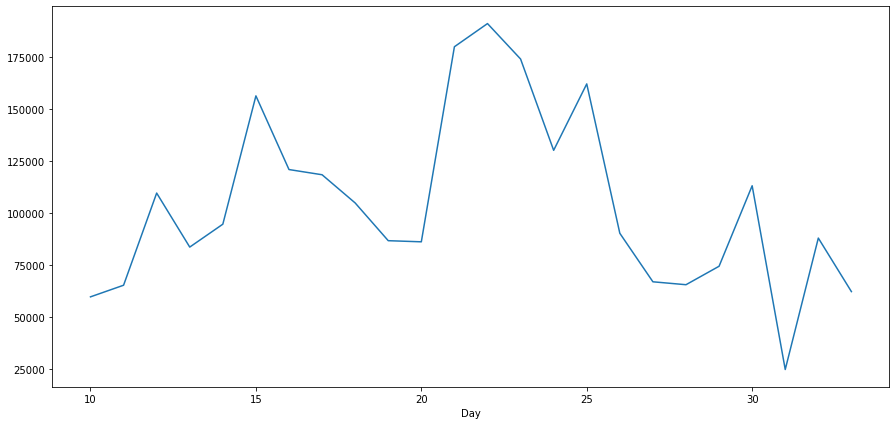

In [4]:
import matplotlib.pyplot as plt # Impot the relevant module

fig, ax = plt.subplots(figsize=(15,7))
df_ipsource.groupby(['Day']).count()['protocoltext'].plot(ax=ax)
#df_ipsource.plot(ax=ax)

In [3]:
df_plot = merged_df['country'].value_counts(dropna=True)
print (df_plot)

United States               4791760
Germany                     1842048
Canada                       981742
United Kingdom               952399
Seychelles                   857062
                             ...   
Marshall Islands                  1
Samoa                             1
Central African Republic          1
Cuba                              1
Cook Islands                      1
Name: country, Length: 210, dtype: int64


<AxesSubplot:xlabel='country'>

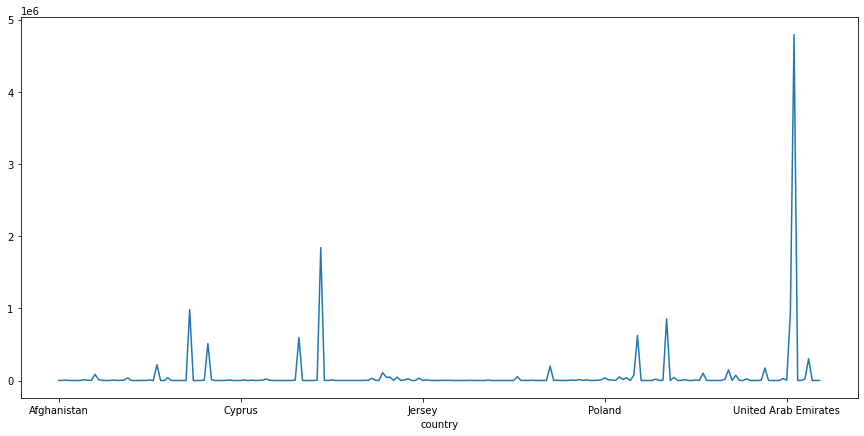

In [4]:
import matplotlib.pyplot as plt # Impot the relevant module

fig, ax = plt.subplots(figsize=(15,7))
#merged_df.groupby(['country']).count()['sourceip'].plot(ax=ax)
groups.plot(ax=ax)

In [ ]:
import pandas as pd


# Extract the data we're interested in
lat, lon = cities['latd'], cities['longd']
population, area = cities['population_total'], cities['area_total_km2']

# Scatter the points, using size and color but no label
plt.scatter(lon, lat, label=None,
            c=np.log10(population), cmap='viridis',
            s=area, linewidth=0, alpha=0.5)
plt.axis(aspect='equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label='log$_{10}$(population)')
plt.clim(3, 7)

# Here we create a legend:
# we'll plot empty lists with the desired size and label
for area in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area) + ' km$^2$')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='City Area')

plt.title('California Cities: Area and Population');

In [ ]:
df_1.dropna(inplace = True)  
  
# percentile list 
perc =[.20, .40, .60, .80] 
  
# list of dtypes to include 
include =['object', 'float', 'int','string'] 
  
# calling describe method 
desc = df_1.describe(percentiles = perc, include = include) 
  
# display 
desc 

In [ ]:
import ipaddress
int(ipaddress.ip_address('1.2.3.4'))
16909060

In [ ]:
from math import pi
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.transform import factor_cmap, cumsum
from bokeh.palettes import Paired12
output_notebook()

In [ ]:
import matplotlib.pyplot as plt # Impot the relevant module

fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
df_1.plot(x = 'sourceip', y = 'country', ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
df_1.plot(x = 'year', y = 'cheese', ax = ax, secondary_y = True) 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


# df has data
colors = ['r' if item == "Unauthorized" else 'g' for item in df_ipsource["Day"]]
df_ipsource.plot(kind='bar', x='Day', y='protocoltext', color=colors, legend=False)
plt.show()

NameError: name 'df_ipsource' is not defined

In [ ]:
df_version6.createOrReplaceTempView('tmp_firewall')

In [ ]:
df2 = spark.read \
    .format('jdbc') \
    .option('driver', properties['driver']) \
    .option('url', properties['url']) \
    .option('user', properties['user']) \
    .option('password', properties['password']) \
    .option('dbtable', properties['dbtable4a']) \
    .load()

In [ ]:
print('DataFrame rows: %d' % df2.count())
print('DataFrame schema: %s' % df2)
df2.show(10, False)